In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from scipy.interpolate import InterpolatedUnivariateSpline
from collections import defaultdict
from collections import OrderedDict
from collections import Counter

In [46]:
def snap_bond_graph(snap):
    """ 
    Given a snapshot from a trajectory return an array
    corresponding to the molecule index of each particle
    Parameters
    ----------
    snap : gsd.hoomd.Snapshot
    Returns
    -------
    numpy array (N_particles,)
    """
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:,0],snap.bonds.group[:,1])),
        shape=(snap.particles.N,snap.particles.N))   
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels

class Molecule:
    def __init__(self, id_num, molecules):
        self.molecule_id = id_num
        self.atom_indices = np.where(molecules == self.molecule_id)[0]
        self.surface_pos = []
        self.surface_frames = []
                
    def atom_types(self, frame):
        type_ids = [frame.particles.typeid[self.atom_indices]]
        atoms = [frame.particles.types[typeid] for typeid in type_ids]
        return atoms
    
    def center_xyz(self, frame):
        positions = frame.particles.position[self.atom_indices]
        molecule_center = np.mean(positions, axis=0)
        return molecule_center
     
    def log_molecule(self, frame_num, frame):
        '''
        Creates a new list for each new surface interaction
        That list contains positions for all consecutive frames
        that the molecule stays on the surface
        I'm allowing a bit of a buffer, if a molecule is off the surface for a single
        frame between 2 frames where it is on the surface, its all counted as the same surface
        interaction.
        '''
        try:
            last_frame = self.surface_frames[-1][-1]
            if last_frame >= frame_num -2: # -2 is the buffer
                self.surface_frames[-1].append(frame_num)
                self.surface_pos[-1].append(self.center_xyz(frame))
            else: # New interaction, append an empty list, then start appending positions
                self.surface_frames.append([])
                self.surface_pos.append([])
                self.surface_frames[-1].append(frame_num)
                self.surface_pos[-1].append(self.center_xyz(frame))
        except:
            self.surface_frames.append([frame_num])
            self.surface_pos.append([self.center_xyz(frame)])
            
    def molecule_msd(self, system_box):
        self.avg_msd, self.msd_std = average_mol_msd(self, box=system_box)
               
            
class System:
    def __init__(self, system):
        self.molecule_labels = snap_bond_graph(system)
        self.mol_count_dict = Counter(self.molecule_labels)
        self.box = system.configuration.box
        
    def get_mol_ids(self, num_mols):
        # This function needs to be more robust
        # Right now, just creates molecule instances based on how many
        # Gas molecules you say are in the system
        # Need better way if we have mixed gasses and want to track them separately
        # Not sure how, maybe something along the lines of SMILES/SMARTS matching?
        molecule_ids = [key for key in self.mol_count_dict]
        molecule_ids.sort()
        return molecule_ids[-num_mols:]
    
    def molecules(self, num_mols):
        return [Molecule(i, self.molecule_labels) for i in self.get_mol_ids(num_mols)]

def msd(position_list, box, mode='window'):
    positions = np.stack(np.array(position_list)[:, np.newaxis])
    mol_msd = freud.msd.MSD(box, mode)
    mol_msd.compute(positions)
    return mol_msd.msd

def average_mol_msd(molecule, box):
    if len(molecule.surface_pos) == 0:
        return [], []
    lengths = [len(pos_list) for pos_list in molecule.surface_pos]
    lengths.sort() # Must go from smallest to largest
    lengths_set = list(OrderedDict.fromkeys(lengths)) # Remove duplicates
    
    msd_results = np.zeros(max(lengths), dtype=float)
    for positions in molecule.surface_pos:
        mol_msd = msd(positions, box=box)
        mol_msd.resize(msd_results.shape) # Resize so we can add to msd_results
        msd_results += mol_msd
        
    standard_deviations = [] # std dev of each bin
    start_index = 0
    divide_by = float(len(molecule.surface_pos))
    for L in lengths_set:
        if L == max(lengths): # Last iteration, slice to the end of msd_results
            num_data_points = len(msd_results[start_index:])
            std_dev = np.std(msd_results[start_index:])
            standard_deviations += num_data_points * [std_dev]
            msd_results[start_index:] /= divide_by
            break
        else: # NOT the last iteration, slice msd_results between start_index & L
            num_data_points = len(msd_results[start_index:L])
            std_dev = np.std(msd_results[start_index:L])
            standard_deviations += num_data_points * [std_dev]
            msd_results[start_index:L] /= divide_by
        start_index = L
        divide_by -= lengths.count(L) # .count handles multiple surface instances of same len
    return msd_results, standard_deviations
    
    
def track_ethanes(gsdfile, num_mols, z_cutoff):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    t = gsd.hoomd.HOOMDTrajectory(f) 
    system = System(t[0])
    ethanes = system.molecules(num_mols) # 50 ethanes
    print('Number of ethane molecules = {}'.format(len(ethanes)))
    
    num_surface_molecules = []
    time_steps = []
    for idx, frame in enumerate(t):
        surface_ethanes = [e for e in ethanes if e.center_xyz(frame)[-1] < z_cutoff]      
        num_surface_molecules.append(len(surface_ethanes))
        time_steps.append(frame.configuration.step)
        for ethane in surface_ethanes: # update statuses
            ethane.log_molecule(idx, frame)
            
    for ethane in ethanes: # After all frames, calculate MSDs for individual molecules
        ethane.molecule_msd(system.box)
        
    return ethanes, system, num_surface_molecules, time_steps

## The cell below runs the `track_ethanes` function on the gsd file which creates each molecule instance and logs all of the positions throughout the trajectory

In [85]:
%%time
gsdfile = "out-D_4x4x2-F1_M1_oplsaa.xml-R_50_traj.gsd"
ethanes, system, num_surface, time_steps = track_ethanes(gsdfile=gsdfile, num_mols = 50, z_cutoff=-7.5)

# ethanes is a list of all of the molecule instances
# This is passed into the average_system_msd function below

Number of ethane molecules = 50
CPU times: user 543 ms, sys: 2.96 ms, total: 546 ms
Wall time: 543 ms


In [89]:
def average_system_msd(molecules, system_box):
    '''
    Lots of comments below for troubleshooting and following the code
    I'll summarize everything here later.
    '''
    # Iterate through each molecule
    # Iterate through each surface interaction of each molecule
    # Accumulate the length (num of frames) for each interaction
    surface_pos_lengths = []
    for mol in molecules:
        if len(mol.surface_pos) > 0: # If = 0; mol never reached the surface
            surface_pos_lengths.extend([len(pos_list) for pos_list in mol.surface_pos])
    surface_pos_lengths.sort() # Must go from smallest to largest
    print('surface_pos_lengths list')
    print(surface_pos_lengths)
    # Remove duplicates, which is required when iterating and slicing msd_results
    # Create new variable because we still need info about the number of MSDs that are
    # of duplicate length
    surface_pos_lengths_set = list(OrderedDict.fromkeys(surface_pos_lengths))
    
    # Start with an array of zeros, equal to the length of the longest surface interaction time
    # Iterate over each molecule
    # Iterate over each of that molecule's surface interactions
    # Add the msd results from each surface interation to the msd_results array
    # msd_results is an accumulation of the MSD of any and all surface interactions
    msd_results = np.zeros(max(surface_pos_lengths), dtype=float)
    for mol in molecules:
        for positions in mol.surface_pos:
            mol_msd = msd(positions, system_box)
            mol_msd.resize(msd_results.shape) # resize so it can be added to msd_results
            msd_results += mol_msd  
    
    # Now we need to normalize msd_results, which to this point is just the summation
    # of all MSDs
    # average_msd = total_msd / N where N is the number of individual MSDs 
    # that contributed to that "bin" of msd_results
    
    # Slice msd_results between start_index and the next length (L)
    # Divide that slice by the # of MSDs that contributed to that bin
    # divide_by keeps track of the # of MSDs that contributed to each bin
    # divide_by starts with the length of surface_pos_lengths since the first bin
    # is an accumulation of every surface interaction MSD
    # After each iteration, divide_by is reduced by the count of L in surface_pos_lengths
    # Example:
        # 5 indiviudal MSDs of lengths 2, 2, 2, 5, and 12 frames each
        # lengths = [2, 2, 2, 5, 12]; divide_by starts at 5 and msd_results[0:2] is divided by 5
        # the next iteration, we want to divide msd_results[2:5] by 2
        # so divide_by = 5 - lengths.count(2) = 5-3 = 2
        # Finally, msd_results[5:12] is the result of only a single MSD, and divide_by = 1
        # NOTE: Not confident if standard deviation calculations here are the way to go
        # But, the standard deviation for each bin is calculated, then appended to 
        # standard_deviations in a way that standard_devations ends up having the same
        # length as msd_results.  The standard devations seem big, as of now they are calcualted
        # on the bin before it is normalzied, maybe it needs to happen after?
    standard_deviations = []
    start_index = 0
    divide_by = float(len(surface_pos_lengths)) 
    for L in surface_pos_lengths_set:
        if L == max(surface_pos_lengths): # the last iteration, slice to end of msd_results
            num_data_points = len(msd_results[start_index:])
            std_dev = np.std(msd_results[start_index:])
            standard_deviations += num_data_points * [std_dev]
            msd_results[start_index:] /= divide_by
        else: # slice between start_index and L
            num_data_points = len(msd_results[start_index:L])
            std_dev = np.std(msd_results[start_index:L])
            standard_deviations += num_data_points * [std_dev]
            msd_results[start_index:L] /= divide_by
        start_index = L
        divide_by -= surface_pos_lengths.count(L)
    return msd_results, standard_deviations

In [90]:
# Run the function on ethanes
sys_msd, sys_msd_std = average_system_msd(ethanes, system.box)

surface_pos_lengths list
[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 9, 9, 9, 9, 10, 10, 11, 12, 12, 12, 12, 12, 14, 15, 19, 27, 31, 37, 59, 60, 73, 74, 110, 119, 142, 143, 143, 156, 178, 185, 186, 189, 189, 195, 200, 204, 215, 216, 217, 221, 225, 228, 234, 303, 325, 330, 340, 353, 390, 402, 409, 425, 443, 446, 484]


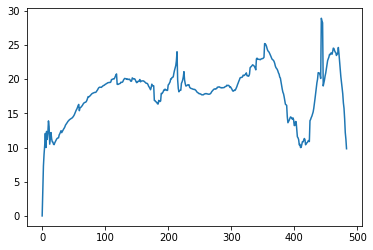

In [58]:
plt.plot(sys_msd)

## Here, you can look at the same process but for individual molecules by changing the index in ethanes[]

### The plot of all individual MSDs are plotted along with the average.

CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 16.7 ms


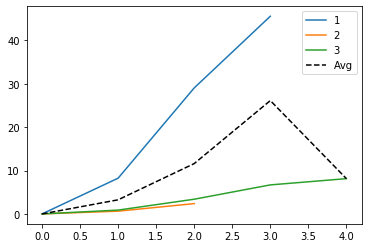

In [88]:
%%time
ethane = ethanes[23]
avg_msd, msd_std = average_mol_msd(ethane, box=system.box)
fig = plt.figure()
for idx, pos in enumerate(ethane.surface_pos):
    plt.plot(msd(pos, system.box), label=idx+1)
plt.plot(avg_msd, label='Avg', linestyle='--', c='k')
#plt.xlim(0, 5)
plt.legend()

In [74]:
# average together everything we have
# how to normalize
# Average speed on the surface
# Track if its in a pore (next to M1) or above the organic layer (but still on surface)
# Don't want to include stuck-in-pore MSDs with the overall surface MSDs --> Keep separate
# Check traj to see what is happening between frame X and frame Y --> Where is it going, does it make sense ?

**-------------------------------------------------**  

**Stuff I've removed, but don't want to delete yet:**

In [150]:
def average_mol_msd_verbose(molecule):
    if len(molecule.surface_pos) == 0:
        return [], []
    lengths = [len(pos_list) for pos_list in molecule.surface_pos]
    lengths.sort() # Must go from smallest to largest
    print(lengths)
    lengths_set = list(OrderedDict.fromkeys(lengths)) # Remove duplicates
    print(lengths_set)
    print()
        # example: [5, 12, 46] --> # of frames spent on surface/used in msd calc
    msd_results = np.zeros(max(lengths), dtype=float)
        # Add everything to msd_results
        # take care of normalization and std. dev in next step
    for positions in molecule.surface_pos:
        mol_msd = msd(positions)
        mol_msd.resize(msd_results.shape) # Resize so we can add to msd_results
        msd_results += mol_msd
        
    standard_deviations = []
    start_index = 0
    divide_by = float(len(molecule.surface_pos))
    for L in lengths_set:
        print("Length = {}".format(L))
        if L == max(lengths):
            print("Last Iteration")
            print("Indices = {}:".format(start_index))
            print("Dividing by {}".format(divide_by))
            num_data_points = len(msd_results[start_index:])
            std_dev = np.std(msd_results[start_index:])
            standard_deviations += num_data_points * [std_dev]
            standard_deviations.append(np.std(msd_results[start_index:]))
            msd_results[start_index:] /= divide_by
            break
        else:
            print('Indices = {}:{}'.format(start_index, L))
            print("Dividing by {}".format(divide_by))
            print('---------------')
            print(msd_results[start_index:L])
            num_data_points = len(msd_results[start_index:L])
            std_dev = np.std(msd_results[start_index:L])
            standard_deviations += num_data_points * [std_dev]
            standard_deviations.append(np.std(msd_results[start_index:L]))
            msd_results[start_index:L] /= divide_by
            print(msd_results[start_index:L])
            print('----------------')
        print()
        start_index = L
        divide_by -= lengths.count(L)
    return msd_results, standard_deviations

In [ ]:
'''
import mbuild as mb

atom_type_dict = {'opls_135': 'C', 'opls_140': 'H', 'opls_145': 'c', 'opls_146': 'H'}
compound = mb.Compound()
for atom_type, pos in zip(benzene_types, benzene_mol_pos):
    species = atom_type_dict[atom_type]
    if species != 'H':
        mb_atom = mb.Compound(name=species, pos=pos)
        compound.add(mb_atom)
compound.add_bond([compound[0], compound[1]])
compound.add_bond([compound[1], compound[2]])
compound.add_bond([compound[2], compound[3]])
compound.add_bond([compound[3], compound[4]])
compound.add_bond([compound[4], compound[5]])
compound.add_bond([compound[5], compound[0]])
'''

In [ ]:
array = np.stack(ethane.surface_instance_pos)
array2 = np.vstack(ethane.surface_instance_pos)
array3 = np.hstack(ethane.surface_instance_pos)
array4 = np.stack(np.array(ethane.surface_instance_pos)[:, np.newaxis])

In [ ]:
'''
def msd(molecule, box=system.box, mode='window'):
    positions = np.stack(np.array(molecule.surface_pos[0:60])[:, np.newaxis])
    mol_msd = freud.msd.MSD(box, mode)
    mol_msd.compute(positions)
    return mol_msd
'''

In [136]:
def surface_msd(gsdfile, atoms_per_mol, z_cutoff):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    t = gsd.hoomd.HOOMDTrajectory(f)
    
    gas = Gas(t[0])
    ethanes = gas.molecules(atoms_per_mol)
    surface_molecules = []
    time_steps = []

    for frame in t:
        pos = [e.center_xyz(frame) for e in ethanes if e.center_xyz(frame)[-1] < z_cutoff]
        surface_molecules.append(len(pos))
        time_steps.append(frame.configuration.step)
        
    fig = plt.figure()
    plt.plot(time_steps, surface_molecules)
    f.close()
    return surface_msd

In [329]:
@property
def atom_indices(self):
    indices = np.where(molecules == self.molecule_id)[0]
    return indices

def find_molecules(snap, atoms_per_mol=8):
    molecules = snap_bond_graph(snap)
    mol_count_dict = Counter(molecules)
    molecule_ids = []
    for key in mol_count_dict:
        if mol_count_dict[key] == atoms_per_mol:
            molecule_ids.append(key)
    return molecules, molecule_ids

def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= 2:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group